### Inception-ResNet-v2 entrenando el modelo para detección de neumonía
### TFM Ingeniería Biomédica

In [1]:
# Descargando la base de datos de Imágenes
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/chest_xray.zip" -d "/content/chest_xray"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Descargando la base de datos de Imágenes
from google.colab import drive
drive.mount('/content/drive')

!unzip -uq "/content/drive/My Drive/dataset.zip" -d "/content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/neumonia.keras" "/content"

In [2]:
# Importaciones
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input
from keras.layers import concatenate
from keras import models # Import the 'models' module for Model
from keras.models import Sequential # If you need Sequential, import it here
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.utils import image_dataset_from_directory  # Updated import for ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import json
import time
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from PIL import Image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from keras.preprocessing import image


In [ ]:
# Definir las rutas donde estan las imagenes
train_dir= '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

In [ ]:
# Definir las rutas donde estan las imagenes
train_dir= '/content/dataset/train'
val_dir = '/content/dataset/val'
test_dir = '/content/dataset/test'

In [5]:
# Rutas del directorio donde están todas las imágenes dataset_completo
train_dir= '/content/dataset_completo/train'
val_dir = '/content/dataset_completo/val'
test_dir = '/content/dataset_completo/test'

In [4]:
# En el caso de dataset debo organizar las imágenes en las carpetas trains, val y test
import os
import shutil
import random

# Directorios originales
original_pneumonia_dir = '/content/dataset/neumonia'
original_normal_dir = '/content/dataset/no-neumonia'

# Directorio base para el dataset
base_dir = '/content/dataset'
#base_dir = '/content/chest_xray' #juntamos los dos dataset

# Crear directorios de entrenamiento, validación y prueba
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Crear subdirectorios para cada clase
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(directory, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(directory, 'PNEUMONIA'), exist_ok=True)

# Mover imágenes de neumonía
pneumonia_images = os.listdir(original_pneumonia_dir)
random.shuffle(pneumonia_images)

for i, image in enumerate(pneumonia_images):
    src = os.path.join(original_pneumonia_dir, image)
    if i < len(pneumonia_images) * 0.6:
        dst = os.path.join(train_dir, 'PNEUMONIA', image)
    elif i < len(pneumonia_images) * 0.8:
        dst = os.path.join(val_dir, 'PNEUMONIA', image)
    else:
        dst = os.path.join(test_dir, 'PNEUMONIA', image)
    shutil.copyfile(src, dst)

# Mover imágenes normales
normal_images = os.listdir(original_normal_dir)
random.shuffle(normal_images)

for i, image in enumerate(normal_images):
    src = os.path.join(original_normal_dir, image)
    if i < len(normal_images) * 0.6:
        dst = os.path.join(train_dir, 'NORMAL', image)
    elif i < len(normal_images) * 0.8:
        dst = os.path.join(val_dir, 'NORMAL', image)
    else:
        dst = os.path.join(test_dir, 'NORMAL', image)
    shutil.copyfile(src, dst)

print('Imágenes movidas exitosamente.')


Imágenes movidas exitosamente.


In [5]:
#Ampliamos el dataset: juntamos las dos fuentes de datos en uno:
import os
import shutil

# Directorios de origen
dataset_dir = '/content/dataset'
chest_xray_dir = '/content/chest_xray'

# Directorio de destino (donde se juntarán las imágenes)
destino_dir = '/content/dataset_completo'

# Crear el directorio de destino si no existe
os.makedirs(destino_dir, exist_ok=True)

# Iterar sobre los conjuntos (test, train, val)
for conjunto in ['test', 'train', 'val']:
    # Iterar sobre las clases (PNEUMONIA, NORMAL)
    for clase in ['PNEUMONIA', 'NORMAL']:
        # Construir las rutas de origen y destino
        origen_dataset = os.path.join(dataset_dir, conjunto, clase)
        origen_chest_xray = os.path.join(chest_xray_dir, conjunto, clase)
        destino = os.path.join(destino_dir, conjunto, clase)

        # Crear el directorio de destino si no existe
        os.makedirs(destino, exist_ok=True)

        # Copiar las imágenes desde el directorio dataset
        for archivo in os.listdir(origen_dataset):
            src = os.path.join(origen_dataset, archivo)
            dst = os.path.join(destino, archivo)
            shutil.copyfile(src, dst)

        # Copiar las imágenes desde el directorio chest_xray
        for archivo in os.listdir(origen_chest_xray):
            src = os.path.join(origen_chest_xray, archivo)
            dst = os.path.join(destino, archivo)
            shutil.copyfile(src, dst)

print("Imágenes combinadas exitosamente.")

Imágenes combinadas exitosamente.


In [3]:
# Dimensiones de las imágenes
img_width, img_height = 299, 299
batch_size = 16

In [6]:
# Configurar el preprocesamiento de imágenes y generadores de datos
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size = batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size = batch_size,
        class_mode='binary',
        shuffle=False)

Found 10907 images belonging to 2 classes.
Found 3767 images belonging to 2 classes.
Found 4229 images belonging to 2 classes.


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 1, 1, 1536)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,698,593 (208.66 MB)

 Trainable params: 54,638,049 (208.43 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [27]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Model

# Dimensiones de las imágenes
img_width, img_height = 299, 299

# Carga el modelo Inception-ResNet-v2 pre-entrenado (sin la capa de clasificación)
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Congela las capas del modelo base para que no se entrenen
#for layer in base_model.layers:
#    layer.trainable = False

# Descongela las últimas 100 capas del modelo base
for layer in base_model.layers[-100:]:
    layer.trainable = True

# Define la capa de entrada
inputs = Input(shape=(img_width, img_height, 3))

# Preprocesa la entrada (necesario para Inception-ResNet-v2)
x = preprocess_input(inputs)

# Pasa la entrada a través del modelo base
x = base_model(x, training=False)

# Agrega capas adicionales para la clasificación binaria
x = AveragePooling2D(pool_size=(8, 8))(x)
x = Flatten()(x)

# Capa densa con regularización L2
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)  # Tasa del 50%

# Capa densa con regularización L1
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.02))(x)
x = Dropout(0.4)(x)

# Capa densa con regularización L1 y L2 combinadas
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02))(x)
x = Dropout(0.3)(x)  # Aumentada la tasa de dropout

predictions = Dense(1, activation='sigmoid')(x)  # Capa de salida para clasificación binaria

# Crea el modelo final
model = Model(inputs=inputs, outputs=predictions)

# Compila el modelo con la función de pérdida binaria
#model.compile(optimizer = 'adam',
optimizer = Adam(learning_rate=0.000001) #0.00001

model.compile(optimizer=optimizer,
              loss = 'binary_crossentropy',
              metrics = ['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_1 (TrueDivide)           │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_1 (Subtract)                │ (None, 299, 299, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 1, 1, 1536)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,698,593 (208.66 MB)

 Trainable params: 54,638,049 (208.43 MB)

 Non-trainable params: 60,544 (236.50 KB)

None


In [ ]:
#Entrenamiento del modelo
nb_epoch = 10
data_augmentation = True

# Model saving callback
checkpointer = ModelCheckpoint(filepath='inceptionresnetv2_neumonia20_21.keras',
                               verbose=1, save_best_only=True)

# Define el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida en el conjunto de validación
    patience=3,          # Número de épocas sin mejora antes de detener el entrenamiento
    verbose=1,          # Imprime mensajes cuando se activa el callback
    restore_best_weights=True  # Restaura los pesos del mejor modelo encontrado
)

if not data_augmentation:
    print('Not using data augmentation.')
    #history = model.fit(x_train, y_train,
    #                    batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
    #                    validation_data=(x_test, y_test), shuffle=True,
    #                    callbacks=[])
    history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpointer, early_stopping]
)
else:
    print('Using real-time data augmentation.')

    # realtime data augmentation
    #datagen_train = ImageDataGenerator(
    #    featurewise_center=False,
    #    samplewise_center=False,
    #    featurewise_std_normalization=False,
    #    samplewise_std_normalization=False,
    #    zca_whitening=False,
    #    rotation_range=0,
    #    width_shift_range=0.125,
    #    height_shift_range=0.125,
    #    horizontal_flip=True,
    #    vertical_flip=False)
    # Añadiendo más trasformaciones
    datagen_train = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=20,  # Agrega rotación
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,  # Agrega cizallamiento en ambas direcciones
        zoom_range=[0.8, 1.2],  # Zoom aleatorio en ambas direcciones
        horizontal_flip=True,
        vertical_flip=False,  # Voltear verticalmente
        brightness_range=[0.8, 1.2],  # Agrega ajuste de brillo
        #fill_mode='nearest'  # Maneja píxeles fuera de los límites
        #brightness_range=[0.5, 1.5],  # Mayor rango de brillo
        #channel_shift_range=0.2,  # Desplazamiento de canales
    )

    class SamplesPerEpochCallback(tf.keras.callbacks.Callback):
      def on_epoch_begin(self, epoch, logs=None):
        print(f"Número de muestras en la época {epoch + 1}: {self.params['steps'] * train_generator.batch_size}")
    # Crea una instancia del callback
    samples_callback = SamplesPerEpochCallback()

    # Ensure the generator loops indefinitely
    train_generator.reset() #Ultimo cambio 15sep

    # Fit the model on the batches generated by datagen.flow()
    # Entrenamos el modelo (se ajusta epochs según sea necesario)
    history = model.fit(train_generator,
          steps_per_epoch=train_generator.samples // train_generator.batch_size,
          epochs=nb_epoch,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // validation_generator.batch_size,
          callbacks=[checkpointer, early_stopping, samples_callback]
          )


In [ ]:
# Optimización de los hiperparámetros
# Se utiliza una técnica de optimización que se utiliza para encontrar la mejor
# combinación de hiperparámetros para un modelo de machine learning.
# En lugar de probar cada combinación posible, se selecciona un conjunto
# de valores para cada hiperparámetro y se evalúa el modelo para todas las
# combinaciones posibles dentro de ese conjunto.
#!pip install scikit-optimize

# Importa las funciones necesarias de skopt
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Definir el espacio de búsqueda (puedes ajustar los rangos y nombres)
space = [
    Real(low=0.000001, high=0.0001, name='learning_rate'),
    Integer(low=16, high=32, name='batch_size'),
    Integer(low=1, high=5, name='epochs'),
    Integer(low=50, high=100, name='n_trainable_layers'),  # Número de capas a descongelar
    Real(low=0.001, high=0.01, name='l1_regularizer'),
    Real(low=0.001, high=0.01, name='l2_regularizer'),
    Categorical(categories=['uniform', 'normal'], name='dropout_type'),  # Tipo de distribución para dropout
    Real(low=0.2, high=0.5, name='dropout_rate'),  # Tasa de dropout
]

# Función objetivo: Entrena un modelo con los hiperparámetros dados y devuelve la pérdida de validación
def objective(params):
    # Clonar el modelo COMPLETO para evitar modificaciones permanentes y mantener la arquitectura
    model_cloned = clone_model(model)

    # Accede a los parámetros por índice (posición en la lista 'space')
    learning_rate = params[0]
    batch_size = params[1]
    epochs = params[2]
    n_trainable_layers = int(params[3])
    l1_regularizer = params[4]
    l2_regularizer = params[5]
    dropout_type = params[6]
    dropout_rate = params[7]

    # Descongela el número especificado de capas en el modelo clonado
    for layer in model_cloned.layers[-n_trainable_layers:]:
        layer.trainable = True

    # Compila el modelo clonado con los hiperparámetros actuales
    model_cloned.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Entrena el modelo clonado usando generadores y early stopping (ajustar paciencia)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    history = model_cloned.fit(train_generator,
                          epochs=epochs,
                          validation_data=validation_generator,
                          callbacks=[early_stopping])

    # Devuelve la pérdida de validación en la última época
    return history.history['val_loss'][-1]

# Ejecuta la búsqueda en cuadrícula
best_params, best_loss = gp_minimize(objective, space, n_calls=20, random_state=12)

# Imprime los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor pérdida de validación: {best_loss}")

682/682 ━━━━━━━━━━━━━━━━━━━━ 696s 733ms/step - accuracy: 0.8486 - loss: 143.0739 - val_accuracy: 0.5023 - val_loss: 83.1682
Epoch 1/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 711s 744ms/step - accuracy: 0.8610 - loss: 130.1465 - val_accuracy: 0.5023 - val_loss: 43.6773
Epoch 2/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 383s 561ms/step - accuracy: 0.9555 - loss: 25.9239 - val_accuracy: 0.4977 - val_loss: 14.3469
Epoch 3/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 384s 562ms/step - accuracy: 0.9536 - loss: 1.5098 - val_accuracy: 0.4977 - val_loss: 66.6777
Epoch 4/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 383s 561ms/step - accuracy: 0.9659 - loss: 0.5076 - val_accuracy: 0.4977 - val_loss: 23.8705
Epoch 1/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 692s 731ms/step - accuracy: 0.8650 - loss: 122.4860 - val_accuracy: 0.4977 - val_loss: 25.0513
Epoch 2/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 380s 557ms/step - accuracy: 0.9407 - loss: 12.9992 - val_accuracy: 0.4977 - val_loss: 18.7544
Epoch 3/5
682/682 ━━━━━━━━━━━━━━━━━━━━ 383s 561ms/step - accuracy: 0.9330 - lo

(raylet) [2024-09-22 22:13:41,644 E 114667 114667] (raylet) node_manager.cc:3065: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: bb7e6268b3e45ac4108cb48ac044c4cfefa76af99dbc8aee64f6d0a1, IP: 172.28.0.12) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.28.0.12`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


682/682 ━━━━━━━━━━━━━━━━━━━━ 385s 564ms/step - accuracy: 0.9475 - loss: 40.5684 - val_accuracy: 0.4977 - val_loss: 16.6367
Epoch 3/4
682/682 ━━━━━━━━━━━━━━━━━━━━ 387s 566ms/step - accuracy: 0.9611 - loss: 4.6850 - val_accuracy: 0.4977 - val_loss: 18.3265
Epoch 4/4
198/682 ━━━━━━━━━━━━━━━━━━━━ 5:03 628ms/step - accuracy: 0.9612 - loss: 0.5815

In [58]:
# Ejecucion en Colab PRO, usando varias GPUs
#kioj!pip install ray
#!pip install ray[tune]


!export RAY_PICKLE_VERBOSE_DEBUG=1

import ray
from ray import tune
from skopt.space import Real, Integer, Categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# Definir el espacio de búsqueda (puedes ajustar los rangos y nombres)
space = {
    "learning_rate": tune.loguniform(1e-5, 1e-3),
    "batch_size": tune.randint(16, 64),
    "epochs": tune.randint(1, 5),
    "n_trainable_layers": tune.randint(50, 150),
    "l1_regularizer": tune.loguniform(1e-3, 1e-1),
    "l2_regularizer": tune.loguniform(1e-3, 1e-1),
    "dropout_type": tune.choice(["uniform", "normal"]),
    "dropout_rate": tune.uniform(0.2, 0.5),
}
def objective1(config):
       learning_rate = config["learning_rate"]
       return learning_rate * 2

# Función objetivo: Entrena un modelo con los hiperparámetros dados y devuelve la pérdida de validación
def objective(config):
    # Clonar el modelo COMPLETO para evitar modificaciones permanentes y mantener la arquitectura
    model_cloned = clone_model(model)

    # Accede a los hiperparámetros desde el diccionario de configuración
    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    epochs = config["epochs"]
    n_trainable_layers = config["n_trainable_layers"]
    l1_regularizer = config["l1_regularizer"]
    l2_regularizer = config["l2_regularizer"]
    dropout_type = config["dropout_type"]
    dropout_rate = config["dropout_rate"]

    # Descongela el número especificado de capas en el modelo clonado
    for layer in model_cloned.layers[-n_trainable_layers:]:
        layer.trainable = True

    # Compila el modelo clonado con los hiperparámetros actuales
    model_cloned.compile(optimizer=Adam(learning_rate=learning_rate),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

    # Entrena el modelo clonado usando generadores y early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    print(f"Config: {config}")
    history = model_cloned.fit(train_generator,
                              epochs=epochs,
                              validation_data=validation_generator,
                              callbacks=[early_stopping])

    print(f"Loss: {history.history['val_loss'][-1]}")  # Print the loss at the end

    # Devuelve la pérdida de validación en la última época
    #tune.report(loss=history.history['val_loss'][-1])
    tune.report(loss=history.history['val_accuracy'][-1])
    #return history.history['val_loss'][-1]
    #return history.history['val_accuracy'][-1]

# Inicializa Ray solo si no se ha inicializado previamente
if not ray.is_initialized():
  ray.init() # Asegúrate de que Ray esté inicializado antes de ejecutar tune.run()
  print("Ray inicializado")

# Ensure the generator loops indefinitely
train_generator.reset()
validation_generator.reset()

# Configurar el experimento de Ray Tune
analysis = tune.run(
    objective,
    config=space,
    resources_per_trial={"gpu": 1},  # Especifica que cada ensayo use 1 GPU
    num_samples=30,  # Número total de ensayos
    storage_path="~/ray_results"
)
#analysis = tune.run(
#    objective,
#    config=space,
#    num_samples=10
#)

# Obtener los mejores resultados
#best_trial = analysis.get_best_trial(metric="loss", mode="min")
best_trial = analysis.get_best_trial(metric="accuracy", mode="max")
# Imprime los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {best_trial.config}") # Use best_trial.config
print(f"Mejor pérdida de validación: {best_trial.last_result['loss']}")
#print(f"Mejor pérdida de validación: {best_loss}")
#print("Mejores hiperparámetros:", best_trial.config)
#print("Mejor pérdida de validación:", best_trial.last_result["loss"])

TypeError: ray.cloudpickle.dumps(<class 'ray.tune.trainable.function_trainable.wrap_function.<locals>.ImplicitFunc'>) failed.
To check which non-serializable variables are captured in scope, re-run the ray script with 'RAY_PICKLE_VERBOSE_DEBUG=1'. Other options: 
-Try reproducing the issue by calling `pickle.dumps(trainable)`. 
-If the error is typing-related, try removing the type annotations and try again.

In [ ]:
# Comprimimos el modelo que es muy grande:
!zip inceptionresnetv2_neumonia10.zip inceptionresnetv2_neumonia10.keras

Forma de la salida de la capa convolucional: (1, 8, 8, 1536)
Gradientes calculados: False
Error: No se pudieron calcular los gradientes.


<ipython-input-63-e8df30d761c2>:72: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)
<ipython-input-63-e8df30d761c2>:116: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)


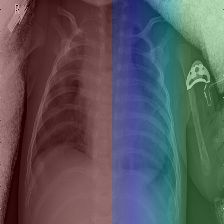

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import numpy as np
import cv2

def compute_heatmap(model, inputs, class_index):
  """
  Calcula el heatmap para una entrada y clase dada.

  Args:
    model: El modelo de Keras.
    inputs: La entrada del modelo.
    class_index: El índice de la clase.

  Returns:
    heatmap: El heatmap calculado.
  """
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    class_channel = predictions[:, class_index]
    # Obtener la salida de la última capa convolucional

    #last_conv_layer = find_layer(model, 'inception_resnet_v2')
    last_conv_layer = model.get_layer('inception_resnet_v2')

    #last_conv_layer = model.get_layer('conv2d_44')  # Reemplaza con el nombre correcto
    last_conv_layer_output = last_conv_layer(inputs)

    # Imprimir la forma del tensor de salida
    print("Forma de la salida de la capa convolucional:", last_conv_layer_output.shape)


    # Aplanar la salida si es necesario
    #if len(last_conv_layer_output.shape) > 2:
    #    last_conv_layer_output = tf.keras.layers.Flatten()(last_conv_layer_output)

    #last_conv_layer = model.get_layer('dense_3')  # última capa convolucional

    # Obtener la salida de la capa convolucional después de ejecutar el modelo
    #last_conv_layer_output = last_conv_layer(inputs)

    # Aplanar la salida de la capa convolucional
    #flatten_layer = tf.keras.layers.Flatten()(last_conv_layer_output)

    #tape.watch(flatten_layer)  # Observar la salida aplanada

    tape.watch(last_conv_layer_output)

  # Calcular gradientes
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Verificar si grads se calculó correctamente
  print("Gradientes calculados:", grads is not None)
  # Check if grads is not None and has the expected shape
  if grads is not None:# and len(grads.shape) == 4:
      #pooled_grads = tf.reshape(grads, shape=(1, 8, 8, 1536))
      pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  else:
      # Handle the case where grads is None or has an unexpected shape
      # For example, you could print an error message or assign a default value to pooled_grads
      print("Error: No se pudieron calcular los gradientes.")
      pooled_grads = tf.zeros((1, 8, 8, 1536))

  # Calcular el heatmap
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)

  heatmap = heatmap.numpy()

  # Normalizar el heatmap
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  #heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
  return heatmap, pooled_grads, last_conv_layer_output


def grad_cam(model, img_path, class_index=0):
    """
    Calcula el mapa de activación de clase graduada para una imagen dada.

    Args:
        model: El modelo de Keras.
        img_path: La ruta a la imagen.
        class_index: El índice de la clase para la cual se calculará el mapa de activación.

    Returns:
        heatmap: El mapa de calor que muestra las regiones importantes.
    """

    # Preprocesar la imagen
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)  # Normalización específica de InceptionResNetV2

    # Calcular el heatmap
    #heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap, _, _ = compute_heatmap(model, x, class_index)

    # Ensure heatmap is a 2D array
    heatmap = heatmap.squeeze()

    # Normalize heatmap to 0-255 and convert to 8-bit unsigned integer
    #heatmap = np.uint8(255 * heatmap)
    #heatmap = np.clip(heatmap, 0, 1)  # Limitar valores entre 0 y 1
    #heatmap = heatmap.astype(np.float64)
    #heatmap /= np.max(heatmap) + 1e-8  # Evitar división por cero
    # Verificar el tipo de datos y convertir si es necesario
    if heatmap.dtype != np.float32 and heatmap.dtype != np.float64:
        print("Convirtiendo heatmap a float32...")
        heatmap = heatmap.astype(np.float32)
    # Apply the colormap
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    #heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Normalizar el heatmap
    #heatmap = np.clip(heatmap, 0, 1)  # Limitar valores entre 0 y 1
    #heatmap /= np.max(heatmap) + 1e-8  # Evitar división por cero

    # Aplicar la paleta de colores
    #heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    #heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convertir a RGB


    # Post-procesamiento
    heatmap = np.maximum(heatmap, 0)
    #heatmap /= np.max(heatmap)

    # Superponer el mapa de calor a la imagen original
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap[0], (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.3, 0)

    return superimposed_img

# Ejemplo de uso
img_path = '/content/dataset_completo/train/PNEUMONIA/PNEUMONIA_1305.jpeg'
heatmap = grad_cam(model, img_path)
# With these lines:
from google.colab.patches import cv2_imshow
cv2_imshow(heatmap)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
print(inputs.shape)

(None, 299, 299, 3)


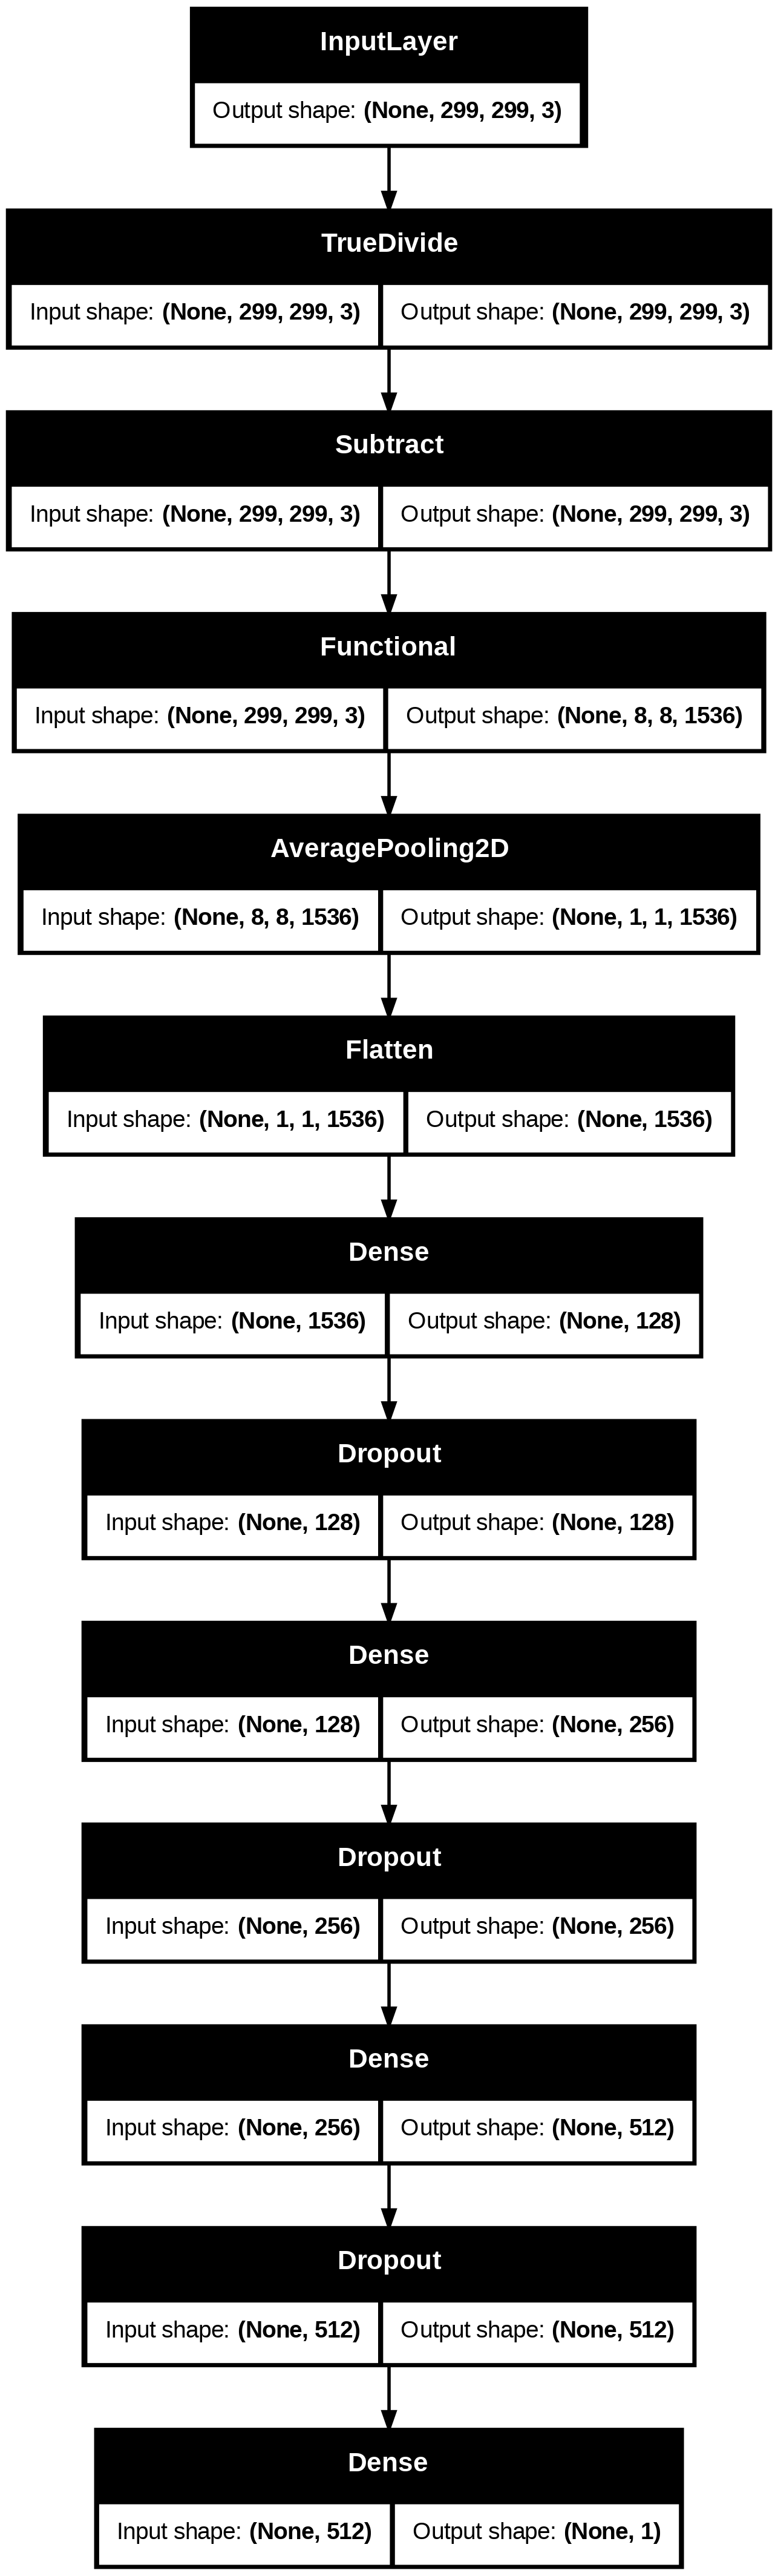

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
def find_layer(model, layer_name):
  for layer in model.layers:
    if isinstance(layer, tf.keras.Model):
      layer = find_layer(layer, layer_name)
      if layer is not None:
        return layer
    if layer.name == layer_name:
      return layer
  return None

last_conv_layer = find_layer(model, 'conv2d_44')
print(last_conv_layer)

<Conv2D name=conv2d_44, built=True>


In [ ]:
# Descargo el modelo:
from google.colab import files
files.download('inceptionresnetv2_neumonia10.keras')

In [ ]:
# Tambien se puede convertir al tflite:
import tensorflow as tf

# Convierte el modelo a TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Guarda el modelo .tflite
with open('inceptionresnetv2_neumonia10.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp3xbjfnze'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_780')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139359894262832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357013827552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011657472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357013826144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011665744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011658880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011664512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011671200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139356913454416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139356913452832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393569134

In [ ]:
# La cuantización reduce la precisión de los pesos y activaciones del modelo,
# lo que puede reducir significativamente el tamaño del modelo y mejorar su
# eficiencia, pero puede afectar al rendimiento

# Ejemplo de cuantización con rango dinámico
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quantized = converter.convert()

# Guarda el modelo .tflite cuantizado
with open('mi_modelo_quantized.tflite', 'wb') as f:
  f.write(tflite_model_quantized)

Saved artifact at '/tmp/tmp2__346km'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_780')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139359894262832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357013827552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011657472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357013826144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011665744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011658880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011664512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139357011671200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139356913454416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139356913452832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393569134

In [1]:
# Graficamos las métricas de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

In [50]:
#test_loss, test_acc = model.evaluate(validation_generator)
test_metrics = model.evaluate(validation_generator)
test_loss = test_metrics[0]  # Loss is the first value
test_acc = test_metrics[1]  # Accuracy is the second value
print('Test accuracy:', test_acc)

# Evaluar el modelo en el conjunto de prueba
test_metrics = model.evaluate(test_generator)

# Imprimir las métricas de prueba
print('Test Loss:', test_metrics[0])
print('Test Accuracy:', test_metrics[1])
print('Test Recall:', test_metrics[2])
print('Test Precision:', test_metrics[3])
print('Test AUC:', test_metrics[4])

# Obtener las predicciones en el conjunto de prueba
y_pred_probabilities = model.predict(test_generator)
y_pred = np.round(y_pred_probabilities)  # Convertir probabilidades a clases (0 o 1)
y_true = test_generator.classes  # Obtener las etiquetas verdaderas del conjunto de prueba

# Calcular el F1-score

f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 150ms/step - accuracy: 0.9030 - auc_4: 0.9677 - loss: 161.5096 - precision_4: 0.9449 - recall_4: 0.8579
Test accuracy: 0.9003962874412537
263/263 ━━━━━━━━━━━━━━━━━━━━ 44s 166ms/step - accuracy: 0.9322 - auc_4: 0.5066 - loss: 161.3979 - precision_4: 0.4351 - recall_4: 0.4554
Test Loss: 161.5176544189453
Test Accuracy: 0.9024274349212646
Test Recall: 0.8625919222831726
Test Precision: 0.9441649913787842
Test AUC: 0.9677771925926208
263/263 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step
F1-score: 0.9015369836695485
[[1915  111]
 [ 299 1877]]


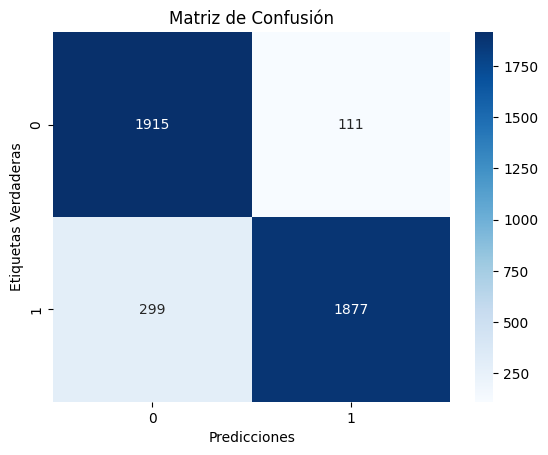

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
#Carga el modelo guardado
from keras.models import load_model
model = load_model('inceptionresnetv2_neumonia10_9.keras')


In [ ]:
from keras.preprocessing import image
# Carga el modelo pre-entrenado
#model = InceptionResNetV2(weights='imagenet')

#model = load_model('neumonia.keras')
#model = load_model('inceptionresnetv2_neumonia10_9.keras')

#model.compile(optimizer = 'adam',
#              loss = 'binary_crossentropy',
#              metrics = ['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()])

# Carga una imagen de ejemplo con neumonía
#img_path = '/content/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg'
#img_path = '/content/dataset/test/PNEUMONIA/BACTERIA-4059589-0002.jpeg'
img_path = '/content/dataset_completo/test/PNEUMONIA/BACTERIA-2034017-0003.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Realiza la predicción
predictions = model.predict(x)

# Imprime las predicciones
#print('Predicted:', decode_predictions(predictions, top=3)[0])
# Imprime la predicción (sin decode_predictions)
# Asumiendo que un valor > 0.5 indica neumonía

print(predictions[0][0])
if predictions[0][0] > 0.5:
    print('Predicted: Pneumonia')
else:
    print('Predicted: Normal')

# Carga una imagen de ejemplo sana
#img_path = '/content/chest_xray/test/NORMAL/IM-0010-0001.jpeg'
#img_path ='/content/dataset/test/NORMAL/IM-0039-0001.jpeg'
img_path ='/content/dataset_completo/test/NORMAL/IM-0039-0001.jpeg'
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Realiza la predicción
predictions = model.predict(x)

# Imprime las predicciones
#print('Predicted:', decode_predictions(predictions, top=3)[0])
# Imprime la predicción (sin decode_predictions)
# Asumiendo que un valor > 0.5 indica neumonía

print(predictions[0][0])
if predictions[0][0] > 0.5:
    print('Predicted: Pneumonia')
else:
    print('Predicted: Normal')

1/1 [==============================] - 5s 5s/step
0.99978083
Predicted: Pneumonia
1/1 [==============================] - 0s 38ms/step
2.309199e-07
Predicted: Normal


In [ ]:
# prompt: Muestra la precisión del la predicción de la neumonía

# ... (código anterior)

# Evaluar el modelo en el conjunto de prueba
test_metrics = model.evaluate(test_generator)

# Imprimir la precisión del modelo en el conjunto de prueba
print('Test Accuracy:', test_metrics[1])


66/66 [==============================] - 19s 291ms/step - loss: 43.1949 - accuracy: 0.9614 - recall: 0.9666 - precision: 0.9566 - auc: 0.9905
Test Accuracy: 0.961391806602478
